# ADAM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [60]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import  classification_report, confusion_matrix, roc_curve, auc

In [2]:
file_path = r'/Users/auser/Downloads/Orginal Image'

In [18]:
name_class = os.listdir(file_path)
# name_class.remove('.DS_Store')
name_class

['2.Corn Husk (Zea mays)',
 '7.Grass Pea Husk (Lathyrus sativus)',
 '1.Rice Husk (Oryza sativa)',
 '6.Soybean Husk (Glycine max)',
 '3.Wheat Husk (Triticum aestivum)',
 '8.Field Pea Husk (Pisum Sativum var. arvense L. Poiret)',
 '5.Lentil Husk (Lens culinaris)',
 '4.Chickpea Husk (Cicer arietinum)']

In [19]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [20]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,/Users/auser/Downloads/Orginal Image/3.Wheat H...,3.Wheat Husk (Triticum aestivum)
1,/Users/auser/Downloads/Orginal Image/3.Wheat H...,3.Wheat Husk (Triticum aestivum)
2,/Users/auser/Downloads/Orginal Image/6.Soybean...,6.Soybean Husk (Glycine max)
3,/Users/auser/Downloads/Orginal Image/1.Rice Hu...,1.Rice Husk (Oryza sativa)
4,/Users/auser/Downloads/Orginal Image/2.Corn Hu...,2.Corn Husk (Zea mays)


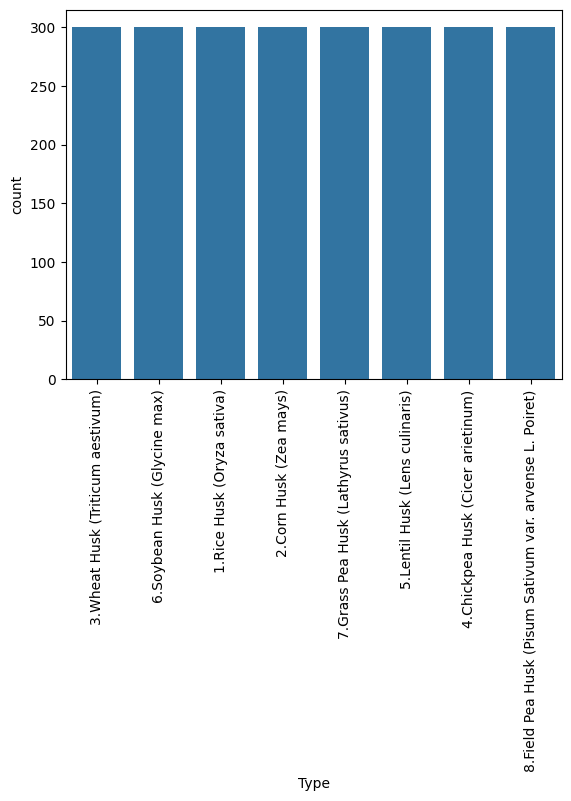

In [21]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [22]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

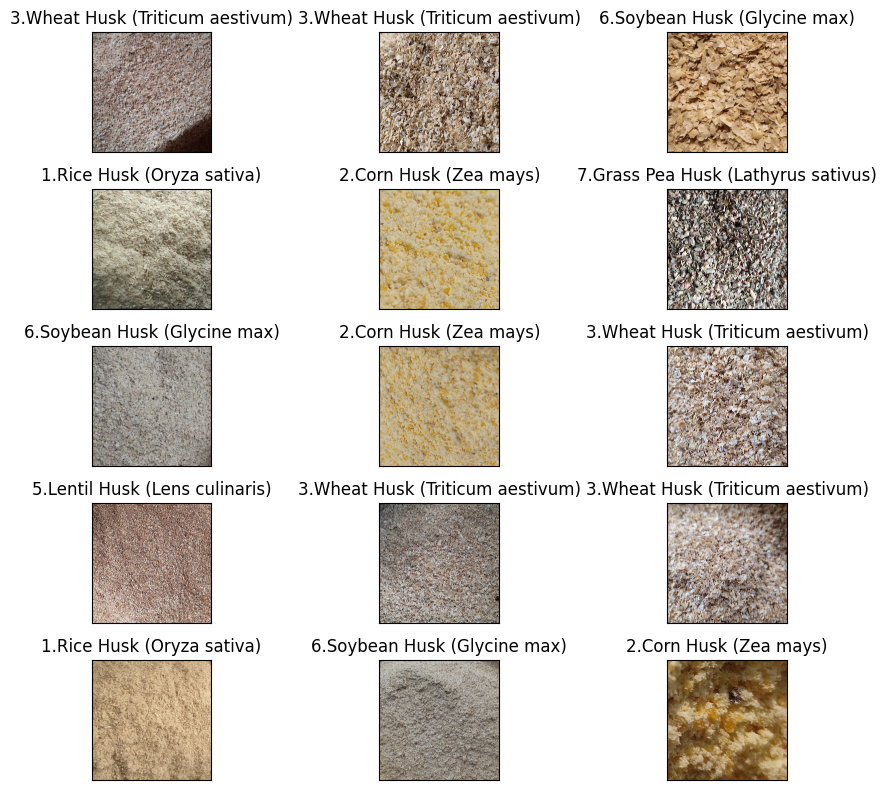

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [24]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.4,1.5],
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [34]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=42
)

Found 1800 validated image filenames belonging to 8 classes.


Found 1800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


In [35]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [39]:
pretrained_model = resnet.ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='/Users/auser/Downloads/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    pooling='avg'
)

pretrained_model.trainable = False

In [40]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [41]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [42]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-02 02:31:56.242569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-02 02:32:04.167737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 120s 7s/step - accuracy: 0.3575 - loss: 2.0539 - val_accuracy: 0.7361 - val_loss: 0.7417
Epoch 2/20


2024-04-02 02:33:54.435226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:34:02.331441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.8037 - loss: 0.6383 - val_accuracy: 0.8300 - val_loss: 0.4611
Epoch 3/20


2024-04-02 02:35:50.087852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:36:01.158487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.8677 - loss: 0.3772 - val_accuracy: 0.8600 - val_loss: 0.4152
Epoch 4/20


2024-04-02 02:37:46.607644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:37:57.279767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.8964 - loss: 0.2961 - val_accuracy: 0.9361 - val_loss: 0.2065
Epoch 5/20


2024-04-02 02:39:44.512239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-02 02:39:52.099074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.9123 - loss: 0.2478 - val_accuracy: 0.9517 - val_loss: 0.1471
Epoch 6/20


2024-04-02 02:41:37.455961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:41:45.397710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.9329 - loss: 0.1717 - val_accuracy: 0.9511 - val_loss: 0.1390
Epoch 7/20


2024-04-02 02:43:31.772098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:43:41.958378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step - accuracy: 0.9383 - loss: 0.1929 - val_accuracy: 0.9217 - val_loss: 0.2324
Epoch 8/20


2024-04-02 02:45:25.179189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:45:35.731372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.9352 - loss: 0.1931 - val_accuracy: 0.9661 - val_loss: 0.1141
Epoch 9/20


2024-04-02 02:47:17.393283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:47:27.343973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 6s/step - accuracy: 0.9563 - loss: 0.1316 - val_accuracy: 0.9644 - val_loss: 0.0980
Epoch 10/20


2024-04-02 02:49:09.283666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:49:19.289882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.9691 - loss: 0.0896 - val_accuracy: 0.9450 - val_loss: 0.1547
Epoch 11/20


2024-04-02 02:51:00.931959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:51:08.861051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.9686 - loss: 0.1067 - val_accuracy: 0.9617 - val_loss: 0.1221
Epoch 12/20


2024-04-02 02:52:54.616732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-02 02:53:02.537217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.9658 - loss: 0.0977 - val_accuracy: 0.9661 - val_loss: 0.0990
Epoch 13/20


2024-04-02 02:54:56.658566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 02:55:04.841055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.9642 - loss: 0.0842 - val_accuracy: 0.9789 - val_loss: 0.0712
Epoch 14/20


2024-04-02 02:57:18.479554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-02 02:57:30.081289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-02 02:57:37.563857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 8s/step - accuracy: 0.9788 - loss: 0.0710 - val_accuracy: 0.9817 - val_loss: 0.0615
Epoch 15/20


2024-04-02 02:59:48.384774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-02 03:00:00.025831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-04-02 03:00:03.800224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.9822 - loss: 0.0616 - val_accuracy: 0.9783 - val_loss: 0.0600
Epoch 16/20


2024-04-02 03:02:16.891121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 03:02:27.530193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-04-02 03:02:31.227861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 9s/step - accuracy: 0.9762 - loss: 0.0716 - val_accuracy: 0.9783 - val_loss: 0.0589
Epoch 17/20


2024-04-02 03:04:47.284243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 03:04:58.087620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-04-02 03:05:02.010071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 9s/step - accuracy: 0.9772 - loss: 0.0548 - val_accuracy: 0.9756 - val_loss: 0.0678
Epoch 18/20


2024-04-02 03:07:16.999485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-02 03:07:27.995372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-02 03:07:35.305535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.9813 - loss: 0.0541 - val_accuracy: 0.9817 - val_loss: 0.0541
Epoch 19/20


2024-04-02 03:09:44.447948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-02 03:09:55.602640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-02 03:10:02.974556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.9809 - loss: 0.0612 - val_accuracy: 0.9383 - val_loss: 0.1575
Epoch 20/20


2024-04-02 03:12:12.578038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-02 03:12:24.037740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-04-02 03:12:27.464052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


15/15 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - accuracy: 0.9581 - loss: 0.1300 - val_accuracy: 0.9750 - val_loss: 0.0795


In [43]:
model.save("blob.h5")

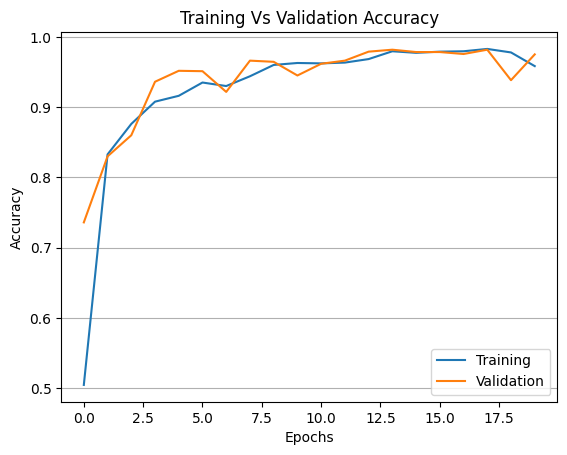

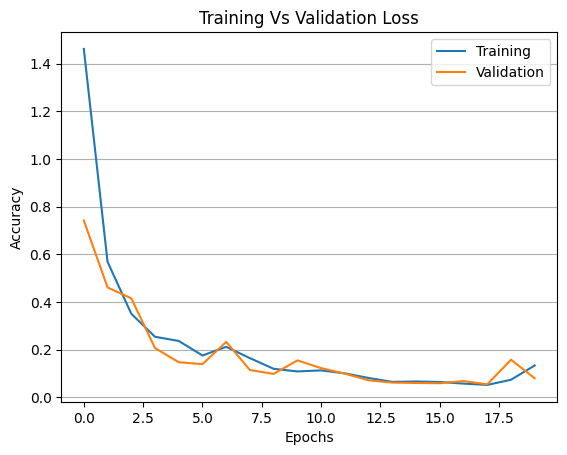

In [44]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Training Vs Validation Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
lst = ["Training", "Validation"]
plt.legend(lst)
plt.grid(axis='y')
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
lst = ["Training", "Validation"]
plt.legend(lst)
plt.grid(axis='y')
plt.show()

In [45]:
results = model.evaluate(test_gen, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.08500
Test Accuracy: 97.33%


In [46]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
auc_pred = pred
pred = np.argmax(pred,axis=1)

confusion_pred = pred
print(pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
[2 3 4 4 2 2 7 1 5 2 1 5 6 6 0 3 4 1 5 2 2 2 6 7 3 0 2 3 6 0 5 5 6 2 6 7 1
 4 4 1 0 3 2 2 5 2 6 3 7 5 3 2 1 6 2 6 2 3 4 3 0 3 4 1 3 2 2 4 5 5 2 3 0 5
 6 0 3 2 1 6 0 0 1 5 2 7 6 6 2 4 0 7 4 3 1 6 2 3 7 6 1 5 4 7 2 6 3 5 4 3 4
 2 6 4 6 4 1 2 6 4 6 6 5 0 4 1 5 2 7 4 6 4 5 6 1 6 5 2 3 2 0 4 5 5 1 2 0 5
 5 5 1 4 3 6 7 5 5 3 4 4 7 1 0 1 0 7 6 0 5 6 0 6 0 4 2 7 7 6 4 4 0 3 0 3 4
 7 5 6 0 3 5 0 6 2 0 7 4 7 4 4 5 0 3 6 7 3 4 6 2 0 2 0 1 5 4 5 6 6 2 5 2 1
 0 5 7 6 4 3 5 5 2 0 0 4 1 5 7 5 1 5 1 4 1 6 3 1 7 7 6 3 3 3 0 3 4 0 1 7 3
 1 5 1 5 0 5 7 5 1 2 4 4 0 0 0 3 6 7 1 2 1 6 3 3 7 5 5 7 6 4 4 2 2 2 2 3 3
 5 7 3 1 3 1 5 7 3 2 1 5 7 1 1 7 5 4 1 4 7 6 1 6 4 5 2 2 0 2 6 0 4 5 1 4 5
 7 1 1 1 1 0 5 5 6 3 2 1 1 3 7 5 7 4 3 4 0 5 6 0 4 7 1 3 0 2 0 6 7 6 0 4 3
 4 1 6 7 6 1 1 4 7 6 7 2 7 0 1 6 7 3 4 7 7 4 1 5 4 7 2 5 7 2 6 2 6 1 3 0 0
 7 2 5 2 4 1 1 2 6 0 1 0 4 2 4 4 6 2 7 2 7 7 1 1 7 1 1 5 6 5 4 0 7 5 0 0 1
 3 7 5 4 7 3 0 1 6 6 3 2 0 3 2 5 2 2 6 0 4 4 4 4 3 4 0 5 0 4 0 

In [50]:
# Map the label
labels = (test_gen.class_indices)
# print(test_gen.labels)
# print(labels)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
print(labels)
print(pred)
# print(labels)
# for i in labels:
    # print(i)

{0: '1.Rice Husk (Oryza sativa)', 1: '2.Corn Husk (Zea mays)', 2: '3.Wheat Husk (Triticum aestivum)', 3: '4.Chickpea Husk (Cicer arietinum)', 4: '5.Lentil Husk (Lens culinaris)', 5: '6.Soybean Husk (Glycine max)', 6: '7.Grass Pea Husk (Lathyrus sativus)', 7: '8.Field Pea Husk (Pisum Sativum var. arvense L. Poiret)'}
['3.Wheat Husk (Triticum aestivum)', '4.Chickpea Husk (Cicer arietinum)', '5.Lentil Husk (Lens culinaris)', '5.Lentil Husk (Lens culinaris)', '3.Wheat Husk (Triticum aestivum)', '3.Wheat Husk (Triticum aestivum)', '8.Field Pea Husk (Pisum Sativum var. arvense L. Poiret)', '2.Corn Husk (Zea mays)', '6.Soybean Husk (Glycine max)', '3.Wheat Husk (Triticum aestivum)', '2.Corn Husk (Zea mays)', '6.Soybean Husk (Glycine max)', '7.Grass Pea Husk (Lathyrus sativus)', '7.Grass Pea Husk (Lathyrus sativus)', '1.Rice Husk (Oryza sativa)', '4.Chickpea Husk (Cicer arietinum)', '5.Lentil Husk (Lens culinaris)', '2.Corn Husk (Zea mays)', '6.Soybean Husk (Glycine max)', '3.Wheat Husk (Triti

In [51]:
y_test = list(test.Label)

# for i in y_test:
#     print(i)

# # len(y_test)
print(classification_report(y_test, pred))

                                                         precision    recall  f1-score   support

                             1.Rice Husk (Oryza sativa)       0.99      0.96      0.97        72
                                 2.Corn Husk (Zea mays)       0.99      1.00      0.99        70
                       3.Wheat Husk (Triticum aestivum)       0.96      0.95      0.96        80
                      4.Chickpea Husk (Cicer arietinum)       1.00      0.92      0.96        71
                         5.Lentil Husk (Lens culinaris)       1.00      0.98      0.99        90
                           6.Soybean Husk (Glycine max)       0.96      0.99      0.98        81
                    7.Grass Pea Husk (Lathyrus sativus)       0.91      1.00      0.95        70
8.Field Pea Husk (Pisum Sativum var. arvense L. Poiret)       0.99      1.00      0.99        66

                                               accuracy                           0.97       600
                            

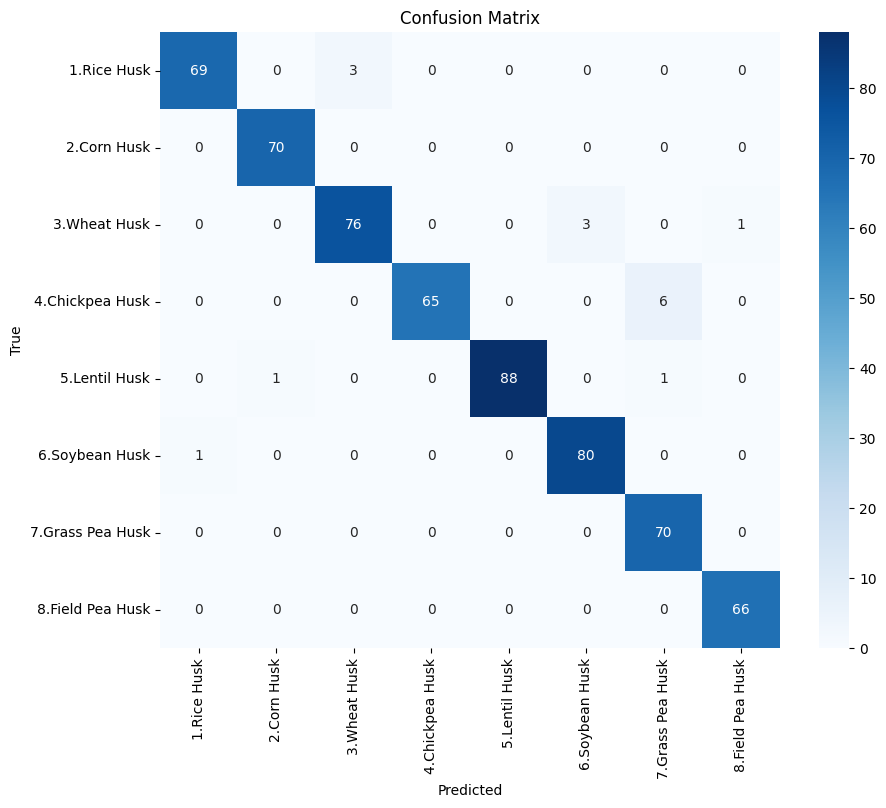

In [55]:
# Generate predictions
# pred = model.predict(test_gen)
# pred = np.argmax(pred, axis=1)

# Get true labels
y_true = test_gen.labels

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, confusion_pred)
names = ["1.Rice Husk", "2.Corn Husk", "3.Wheat Husk", "4.Chickpea Husk", "5.Lentil Husk", "6.Soybean Husk", "7.Grass Pea Husk", "8.Field Pea Husk"]
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


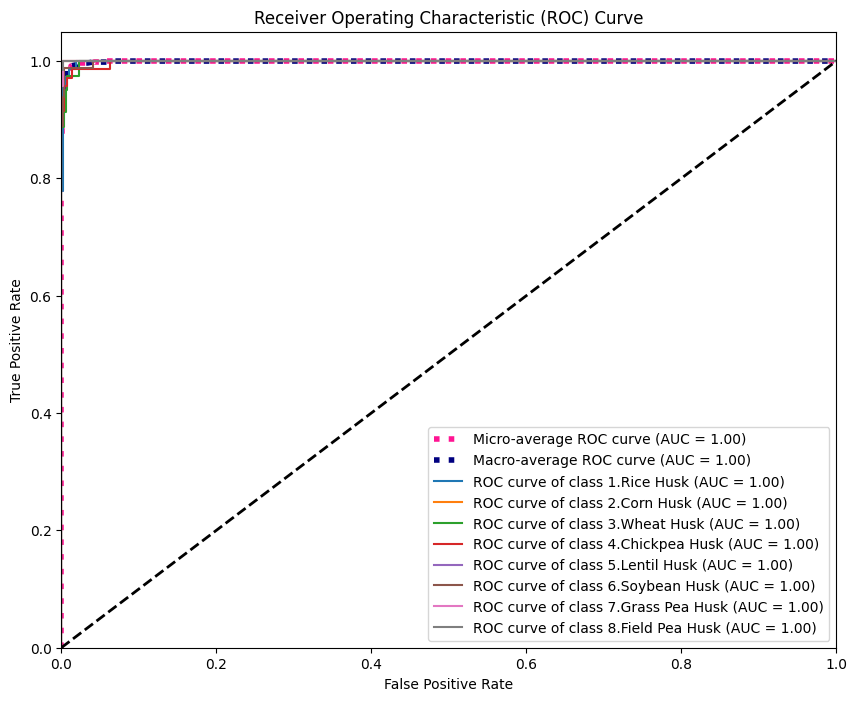

In [62]:
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
auc_y_true = label_binarizer.fit_transform(y_true)

# Convert predictions to probabilities
# pred_prob = model.predict(test_gen)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(auc_y_true[:, i], auc_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(auc_y_true.ravel(), auc_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(labels)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(labels)
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:0.2f})', color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (AUC = {roc_auc_macro:0.2f})', color='navy', linestyle=':', linewidth=4)

for i in range(len(names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
